# Data Files


In [38]:
import os
import pandas as pd
import numpy as np
import statsmodels.api as sm
from scipy import stats
import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy.stats import t
import warnings
from statsmodels.tools.sm_exceptions import IterationLimitWarning
from concurrent.futures import ProcessPoolExecutor
from concurrent.futures import ThreadPoolExecutor


warnings.simplefilter("ignore", IterationLimitWarning)

In [17]:
baseline = pd.read_stata("data/raw/2013-0533_data_baseline.dta")
census = pd.read_stata("data/raw/2013-0533_data_census.dta")
endline1_2 = pd.read_stata("data/raw/2013-0533_data_endlines1and2.dta")
endline1bustype = pd.read_stata("data/raw/2013-0533_data_endline1businesstype.dta")

# Figures 2-5

In [39]:
def one_boot(idx, rows, y, X, q):
    """Worker for one bootstrap draw – no pandas, only NumPy."""
    y_b  = y[rows]
    X_b  = X[rows, :]
    try:
        return sm.QuantReg(y_b, X_b).fit(q=q, max_iter=5000, p_tol=1e-6).params[1]
    except Exception:
        return np.nan # skipped draws return nan

def quantile_treatment_effect(df, outcome_var, treat_var='treat_dummy',
                                   cluster_var='areaid',
                                   quantiles=np.arange(0.05, 0.98, 0.02),
                                   n_bootstrap=100, ci=0.90,
                                   n_jobs=os.cpu_count()):
    start = time.time()

    sub_df = df[[outcome_var, treat_var, cluster_var]].dropna()
    y = sub_df[outcome_var].to_numpy()
    X = sm.add_constant(sub_df[treat_var]).to_numpy()
    clusters = sub_df[cluster_var].to_numpy()
    cluster_ids = np.unique(clusters)

    results = []
    np.random.seed(65209844)
    for q in tqdm(quantiles, "Progress"):
        # point estimate (quantile) and OLS
        q_model = sm.QuantReg(y, X).fit(q=q, max_iter=1000, p_tol=1e-6)
        q_est   = q_model.params[1]

        ols_est = sm.OLS(y, X).fit(
            cov_type='cluster', cov_kwds={'groups': clusters}
        ).params[1]

        boot_rows = []
        for _ in range(n_bootstrap):
            sampled_clusters = np.random.choice(cluster_ids, size=len(cluster_ids), replace=True)
            boot_rows.append(np.isin(clusters, sampled_clusters).nonzero()[0])


        # parallel bootstrap
        with ThreadPoolExecutor(max_workers=n_jobs) as pool:
            boot_coefs = list(pool.map(
                one_boot,
                range(n_bootstrap),
                boot_rows,
                [y]*n_bootstrap,
                [X]*n_bootstrap,
                [q]*n_bootstrap
            ))

        boot_coefs = np.asarray(boot_coefs, dtype=float)
        boot_coefs = boot_coefs[~np.isnan(boot_coefs)] # drop failed fits
        se  = boot_coefs.std(ddof=1)
        ts  = t.ppf(1-(1-ci)/2, df=len(boot_coefs)-1)
        ci_lower, ci_upper = q_est - ts*se, q_est + ts*se

        results.append((q, ols_est, q_est, ci_lower, ci_upper))

    time_taken = time.time() - start
    print(f"Finished {len(quantiles)} quantiles × {n_bootstrap} reps"
          f"  in {time_taken:.1f}s  [{n_jobs} cores]")

    out = pd.DataFrame(results, columns=['quantile','ols','qte','ci_lower','ci_upper'])
    out['percentile'] = (out['quantile']*100).astype(int)
    return out


Progress:  28%|██▊       | 13/47 [00:39<03:39,  6.46s/it]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress:  47%|████▋     | 22/47 [01:13<01:42,  4.09s/it]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress:  57%|█████▋    | 27/47 [01:30<01:12,  3.61s/it]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress:  60%|█████▉    | 28/47 [01:33<01:05,  3.42s/it]/Library/Frameworks/Python.framework/Ver

Finished 47 quantiles × 100 reps  in 151.0s  [8 cores]


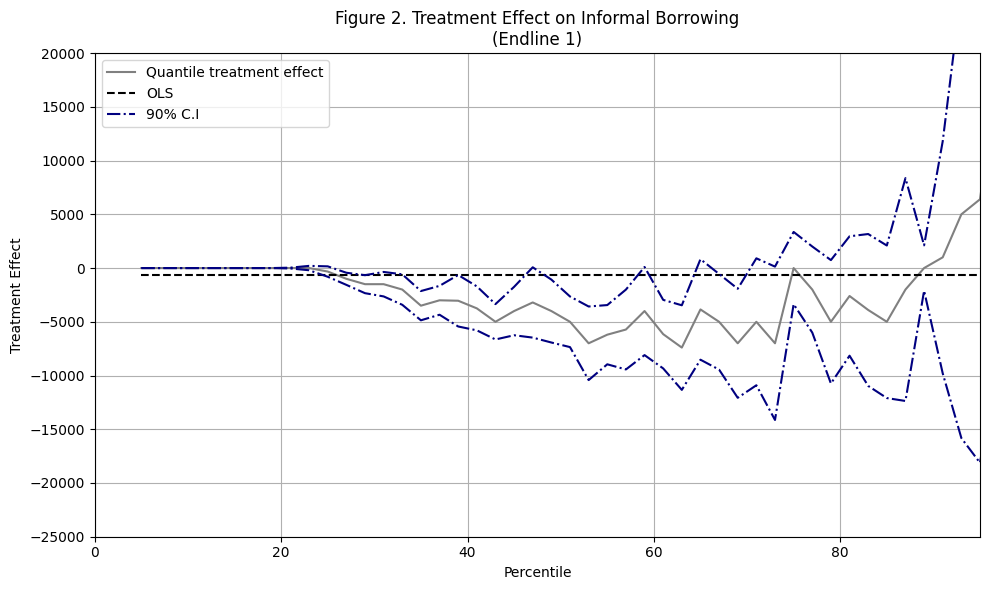

In [40]:
# ==== Figure 2: Informal Borrowing ====
df = endline1_2
df['treat_dummy'] = (df['treatment'] == 'Treatment').astype(int)
fig2_df = quantile_treatment_effect(df, 'informal_amt_1')
plt.figure(figsize=(10, 6))
plt.plot(fig2_df['percentile'], fig2_df['qte'], color='gray', label='Quantile treatment effect')
plt.plot(fig2_df['percentile'], fig2_df['ols'], linestyle='--', color='black', label='OLS')
plt.plot(fig2_df['percentile'], fig2_df['ci_lower'], linestyle='-.', color='navy', label='90% C.I')
plt.plot(fig2_df['percentile'], fig2_df['ci_upper'], linestyle='-.', color='navy')
plt.title('Figure 2. Treatment Effect on Informal Borrowing\n(Endline 1)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect')
plt.grid(True)
plt.xlim(0, 95)
plt.ylim(-25000, 20000)
plt.legend()
plt.tight_layout()
# plt.savefig("figure2.pdf", bbox_inches='tight')
plt.show()

Progress:   0%|          | 0/47 [00:00<?, ?it/s]

Progress: 100%|██████████| 47/47 [01:32<00:00,  1.96s/it]

Finished 47 quantiles × 100 reps  in 92.2s  [8 cores]


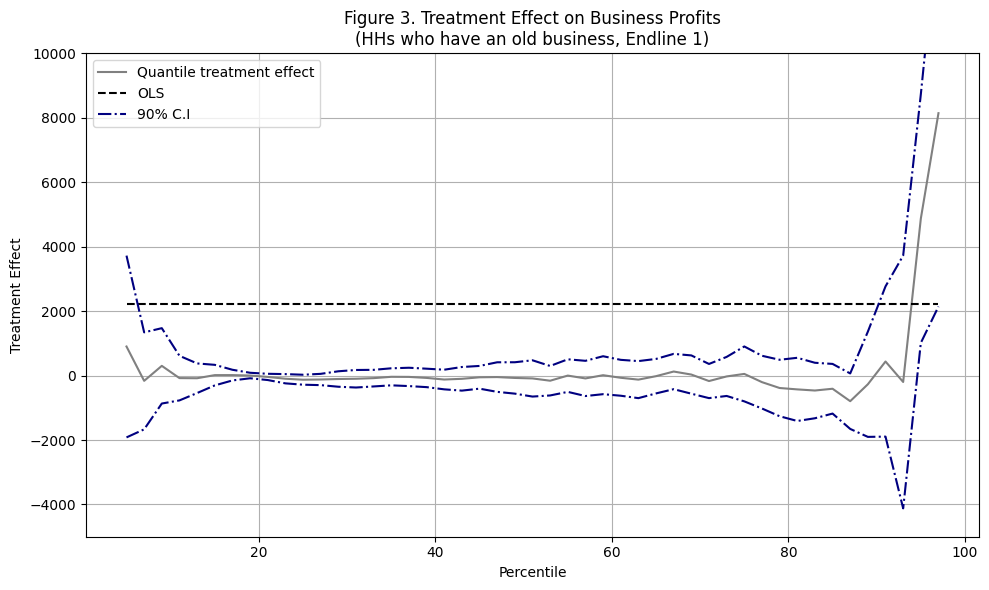

In [41]:
# ==== Figure 3: Business Profits - Old Businesses EL1 ====
df['bizprofit_1_old'] = df.loc[df['any_old_biz'] == 'Yes', 'bizprofit_1']
fig3_df = quantile_treatment_effect(df, 'bizprofit_1_old')
plt.figure(figsize=(10, 6))
plt.plot(fig3_df['percentile'], fig3_df['qte'], color='gray', label='Quantile treatment effect')
plt.plot(fig3_df['percentile'], fig3_df['ols'], linestyle='--', color='black', label='OLS')
plt.plot(fig3_df['percentile'], fig3_df['ci_lower'], linestyle='-.', color='navy', label='90% C.I')
plt.plot(fig3_df['percentile'], fig3_df['ci_upper'], linestyle='-.', color='navy')
plt.title('Figure 3. Treatment Effect on Business Profits\n(HHs who have an old business, Endline 1)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect')
plt.grid(True)
plt.ylim(-5000, 10000)
plt.legend()
plt.tight_layout()
# plt.savefig("figure3.pdf", bbox_inches='tight')
plt.show()

/var/folders/mc/80j622jd5f1g317z7lpps7v00000gn/T/ipykernel_54505/2115183163.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['bizprofit_1_new'] = df.loc[(df['any_old_biz'] == 'No') & (df['any_biz_1'] == 1) &
Progress:  85%|████████▌ | 40/47 [00:26<00:04,  1.42it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress: 100%|██████████| 47/47 [00:31<00:00,  1.49it/s]

Finished 47 quantiles × 100 reps  in 31.6s  [8 cores]


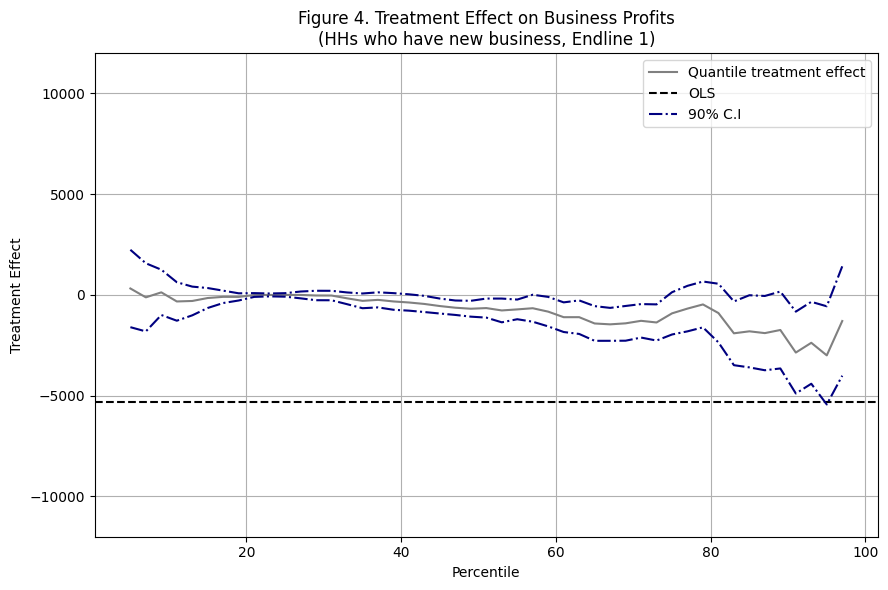

In [42]:
# ==== Figure 4: Business Profits - New Businesses EL1 ====
df['bizprofit_1_new'] = df.loc[(df['any_old_biz'] == 'No') & (df['any_biz_1'] == 1) &
                               (df['bizprofit_1'].between(-20000, 20000)), 'bizprofit_1']
fig4_df = quantile_treatment_effect(df, 'bizprofit_1_new')

# Get OLS on full untrimmed data
ols_df = df.loc[(df['any_old_biz'] == 'No') & (df['any_biz_1'] == 1)]
ols_y = ols_df['bizprofit_1']
ols_X = sm.add_constant(ols_df['treat_dummy'])
ols_model = sm.OLS(ols_y, ols_X, missing='drop').fit()
ols_value = ols_model.params['treat_dummy']

plt.figure(figsize=(9, 6))
plt.plot(fig4_df['percentile'], fig4_df['qte'], color='gray', label='Quantile treatment effect')
plt.axhline(y=ols_value, linestyle='--', color='black', label='OLS')
plt.plot(fig4_df['percentile'], fig4_df['ci_lower'], linestyle='-.', color='navy', label='90% C.I')
plt.plot(fig4_df['percentile'], fig4_df['ci_upper'], linestyle='-.', color='navy')
plt.title('Figure 4. Treatment Effect on Business Profits\n(HHs who have new business, Endline 1)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect')
plt.grid(True)
plt.ylim(-12000, 12000)
plt.legend()
plt.tight_layout()
# plt.savefig("figure4.pdf", bbox_inches='tight')
plt.show()

Progress:   0%|          | 0/47 [00:00<?, ?it/s]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress:  64%|██████▍   | 30/47 [01:04<00:33,  2.00s/it]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress:  91%|█████████▏| 43/47 [01:30<00:08,  2.23s/it]/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/statsmodels/regression/quantile_regression.py:187: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)
Progress: 100%|██████████| 47/47 [01:40<00:00,  2.15s/it]

Finished 47 quantiles × 100 reps  in 100.8s  [8 cores]


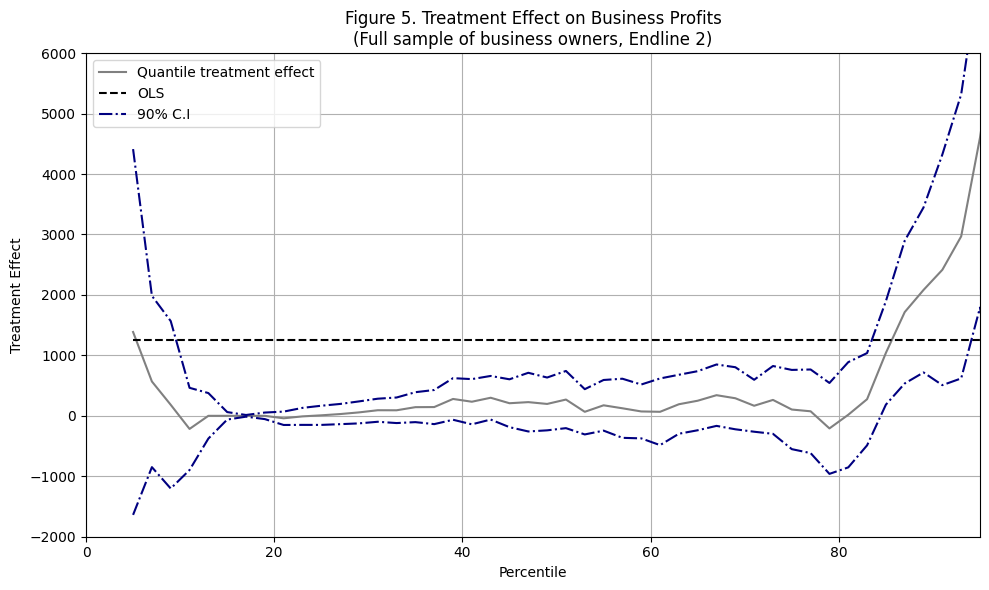

In [55]:
# ==== Figure 5: Business Profits - All Businesses EL2 ====
df['bizprofit_2_biz'] = df.loc[df['any_biz_2'] == 1, 'bizprofit_2']
fig5_df = quantile_treatment_effect(df, 'bizprofit_2_biz')
plt.figure(figsize=(10, 6))
plt.plot(fig5_df['percentile'], fig5_df['qte'], color='gray', label='Quantile treatment effect')
plt.plot(fig5_df['percentile'], fig5_df['ols'], linestyle='--', color='black', label='OLS')
plt.plot(fig5_df['percentile'], fig5_df['ci_lower'], linestyle='-.', color='navy', label='90% C.I')
plt.plot(fig5_df['percentile'], fig5_df['ci_upper'], linestyle='-.', color='navy')
plt.title('Figure 5. Treatment Effect on Business Profits\n(Full sample of business owners, Endline 2)')
plt.xlabel('Percentile')
plt.ylabel('Treatment Effect')
plt.grid(True)
plt.xlim(0, 95)
plt.ylim(-2000, 6000)
plt.legend()
plt.tight_layout()
# plt.savefig("figure5.pdf", bbox_inches='tight')
plt.show()

# Tables

In [44]:
# Define variable groups from the Stata locals
hh_composition = ["hh_size", "adults", "children", "male_head", "head_age", "head_noeduc"]
credit_access = ["spandana", "othermfi", "bank", "informal", "anyloan"]
loan_amt = ["spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt"]
self_emp_activ = ["total_biz", "female_biz", "female_biz_pct"]
businesses = ["bizrev", "bizexpense", "bizinvestment", "bizemployees", "hours_weekbiz"]
businesses_allHH = ["bizrev_allHH", "bizexpense_allHH", "bizinvestment_allHH", "bizemployees_allHH", "hours_weekbiz_allHH"]
consumption = ["total_exp_mo", "nondurable_exp_mo", "durables_exp_mo", "home_durable_index"]

# Combine all into a single list
allvars = (
    hh_composition
    + credit_access
    + loan_amt
    + self_emp_activ
    + businesses
    + businesses_allHH
    + consumption
)

In [45]:
#############################################
################# Table 1A ##################
#############################################
# Create Summary Statistics Table
df1a = baseline.copy()
for var in businesses:
    df1a[f"{var}_allHH"] = df1a[var]
    df1a.loc[df1a["total_biz"] == 0, f"{var}_allHH"] = 0

#) Convert every “Yes”/“No” column to a numeric 0/1:
for col in ['spandana','othermfi','bank','informal','anyloan']:
    df1a[col] = df1a[col].map({'No': 0, 'Yes': 1})


results = []

for var in allvars:

    df = df1a[[var,'treatment','areaid']].copy()

    # ensure the encoded treatment dummy is only 0 and 1 for Treatment and Control
    df['treat_dummy'] = df['treatment'].map({'Treatment': 1, 'Control': 0})
    df = df.dropna(subset=[var, "treat_dummy", "areaid"])

    control = df[df['treat_dummy'] == 0].dropna()
    control[var] = control[var].astype('int64')
    N_ctrl    = control.shape[0]
    mean_ctrl = control[var].mean()
    sd_ctrl   = control[var].std(ddof=1)



    # b) cast numeric
    y = df[var].astype(float)

    X = sm.add_constant(df['treat_dummy'])
    ols = sm.OLS(y, X).fit()
    clust = ols.get_robustcov_results(
        cov_type='cluster',
        groups=df['areaid']
    )
    # d) pull out coefficient + p-value
    coef = clust.params[1]
    pval = clust.pvalues[1]

    results.append({
        "variable":     var,
        "Obs":          N_ctrl,
        "Control_mean": mean_ctrl,
        "Control_sd":   sd_ctrl,
        "Difference":   coef,
        "p_val":        pval
    })

table1a = pd.DataFrame(results).set_index("variable")
print()
print()
print("Table 1A: Baseline Summary Statistics")
print()
print(table1a)
print()
latex_df1a = table1a.to_latex(caption = None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df1a)




Table 1A: Baseline Summary Statistics

                      Obs  Control_mean     Control_sd   Difference     p_val
variable                                                                     
hh_size              1220      5.037705       1.666212     0.095082  0.303395
adults               1220      3.438525       1.465599    -0.011475  0.873081
children             1220      1.599180       1.228256     0.104098  0.098241
male_head            1216      0.907072       0.290450    -0.012249  0.381052
head_age             1216     41.149671      10.839448    -0.243498  0.676189
head_noeduc          1216      0.370066       0.483021    -0.007699  0.786923
spandana             1213      0.000000       0.000000     0.006568  0.195115
othermfi             1213      0.010717       0.103010     0.006524  0.452551
bank                 1213      0.036274       0.187047     0.001493  0.858800
informal             1213      0.632317       0.482373     0.001509  0.958216
anyloan              12

In [46]:
#############################################
################# Table 1B ##################
#############################################


df_orig = endline1_2
df      = df_orig.copy()

businesses = ["bizrev", "bizexpense", "bizinvestment", "bizemployees", "hours_week_biz"]
for i in [1, 2]:
    suf = f"_{i}"
    for var in businesses + ["female_biz"]:
        df[f"{var}_allHH{suf}"] = df[f"{var}{suf}"]
        mask = df[f"total_biz{suf}"] == 0
        df.loc[mask, f"{var}{suf}"] = np.nan

hh_composition    = ["hhsize", "adults", "children", "male_head", "head_age", "head_noeduc"]
credit_access     = ["spandana", "othermfi", "anybank", "anyinformal", "anyloan"]
loan_amt          = ["spandana_amt", "othermfi_amt", "bank_amt", "informal_amt", "anyloan_amt"]
self_emp_activ    = ["total_biz", "female_biz_allHH", "female_biz_pct"]
businesses_allHH  = [v + "_allHH" for v in businesses]
consumption       = ["total_exp_mo", "nondurable_exp_mo", "durables_exp_mo", "home_durable_index"]

allvars = (
    hh_composition
    + credit_access
    + loan_amt
    + self_emp_activ
    + businesses
    + businesses_allHH
    + consumption
)

# rename var_1 -> var1, var_2 -> var2
for var in allvars:
    df.rename(
        columns={f"{var}_1": f"{var}1", f"{var}_2": f"{var}2"},
        inplace=True
    )

df_long = pd.wide_to_long(
    df,
    stubnames=allvars,
    i=["hhid", "areaid", "treatment"],
    j="endline",
    sep="",
    suffix="\\d+"
).reset_index()

# dummy for endline==2
df_long["endline2"] = (df_long["endline"] == 2).astype(int)

# keep only what we need
df_long = df_long[["hhid", "areaid", "treatment", "endline", "endline2"] + allvars]

# Coerce any categorical analysis vars to numeric 0/1 codes
for var in allvars:
    if isinstance(df_long[var].dtype, pd.CategoricalDtype):
        df_long[var] = df_long[var].cat.codes.replace(-1, np.nan)
    else:
        df_long[var] = pd.to_numeric(df_long[var], errors="coerce")

# Calculate summary stats & cluster‐robust OLS for the Control group
results = []
control = df_long[df_long["treatment"] == "Control"]

for var in allvars:
    # Endline 1
    v1 = control.loc[control["endline"] == 1, var].dropna()
    N1, mean1, sd1 = v1.count(), v1.mean(), v1.std(ddof=1)
    # Endline 2
    v2 = control.loc[control["endline"] == 2, var].dropna()
    N2, mean2, sd2 = v2.count(), v2.mean(), v2.std(ddof=1)

    # Cluster‐robust regression of var on endline2
    regdf = control[["areaid", "endline2", var]].dropna(subset=[var])
    X = sm.add_constant(regdf["endline2"])
    y = regdf[var]
    m = sm.OLS(y, X).fit(
        cov_type="cluster",
        cov_kwds={"groups": regdf["areaid"]}
    )
    diff  = m.params["endline2"]
    p_val = m.pvalues["endline2"]

    results.append([N1, mean1, sd1, N2, mean2, sd2, diff, p_val])

table1b = pd.DataFrame(
    results,
    index=allvars,
    columns=[
        "Obs_el1", "Control_mean_el1", "Control_sd_el1",
        "Obs_el2", "Control_mean_el2", "Control_sd_el2",
        "Difference", "p_value"
    ]
)


table1b = table1b.round(2)

display(table1b)
latex_df1b = table1b.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df1b)

,Obs_el1,Control_mean_el1,Control_sd_el1,Obs_el2,Control_mean_el2,Control_sd_el2,Difference,p_value
hhsize,3264,5.65,2.15,2943,6.27,2.55,0.62,0.00
adults,3264,3.89,1.75,2943,4.04,1.85,0.15,0.00
children,3264,1.74,1.31,2943,1.76,1.32,0.03,0.24
male_head,3261,0.89,0.31,2938,0.81,0.39,-0.08,0.00
head_age,3257,41.15,10.22,2940,42.26,10.15,1.11,0.00
head_noeduc,3256,0.31,0.46,2940,0.29,0.45,-0.02,0.02
spandana,3247,0.05,0.22,2943,0.11,0.31,0.06,0.00
othermfi,3183,0.15,0.36,2943,0.27,0.44,0.12,0.00
anybank,3247,0.08,0.27,2943,0.07,0.26,-0.01,0.48
anyinformal,3247,0.76,0.43,2943,0.60,0.49,-0.16,0.00


\begin{tabular}{lccccc}
\toprule
 & Obs_el1 & Control_mean_el1 & Control_sd_el1 & Obs_el2 & Control_mean_el2 & Control_sd_el2 & Difference & p_value \\
\midrule
\textbf{hhsize} & 3264 & 5.65 & 2.15 & 2943 & 6.27 & 2.55 & 0.62 & 0.00 \\
\textbf{adults} & 3264 & 3.89 & 1.75 & 2943 & 4.04 & 1.85 & 0.15 & 0.00 \\
\textbf{children} & 3264 & 1.74 & 1.31 & 2943 & 1.76 & 1.32 & 0.03 & 0.24 \\
\textbf{male_head} & 3261 & 0.89 & 0.31 & 2938 & 0.81 & 0.39 & -0.08 & 0.00 \\
\textbf{head_age} & 3257 & 41.15 & 10.22 & 2940 & 42.26 & 10.15 & 1.11 & 0.00 \\
\textbf{head_noeduc} & 3256 & 0.31 & 0.46 & 2940 & 0.29 & 0.45 & -0.02 & 0.02 \\
\textbf{spandana} & 3247 & 0.05 & 0.22 & 2943 & 0.11 & 0.31 & 0.06 & 0.00 \\
\textbf{othermfi} & 3183 & 0.15 & 0.36 & 2943 & 0.27 & 0.44 & 0.12 & 0.00 \\
\textbf{anybank} & 3247 & 0.08 & 0.27 & 2943 & 0.07 & 0.26 & -0.01 & 0.48 \\
\textbf{anyinformal} & 3247 & 0.76 & 0.43 & 2943 & 0.60 & 0.49 & -0.16 & 0.00 \\
\textbf{anyloan} & 3264 & 0.87 & 0.34 & 2943 & 0.90 & 0.29 

In [47]:
#############################################
################# Table 2 ###################
#############################################

def addstars_table2(df):
    """
    Format the regression results from make_table() by adding stars and
    formatting coefficient (se) as a string column for Table 2 output.
    """
    def stars(p):
        return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

    # Create a new column with formatted coef(se) and stars
    df = df.copy()
    df["coef(se)"] = df.apply(
        lambda row: f"{row['coef']:.3f}{stars(row['pval'])} ({row['se']:.3f})", axis=1
    )

    # Rearrange columns for display
    return df[["coef(se)", "mean_ctrl", "sd_ctrl", "N", "pval"]].round(2)



# list of controls used in the Stata $area_controls macro
area_controls = [
    "area_pop_base",
    "area_debt_total_base",
    "area_business_total_base",
    "area_exp_pc_mean_base",
    "area_literate_head_base",
    "area_literate_base",
]

# Panel A: Endline 1 variables & weight
vars_1 = [
    "spandana_1", "othermfi_1", "anymfi_1", "anybank_1", "anyinformal_1", "anyloan_1",
    "everlate_1", "mfi_loan_cycles_1",
    "spandana_amt_1", "othermfi_amt_1", "anymfi_amt_1", "bank_amt_1", "informal_amt_1",
    "anyloan_amt_1", "credit_index_1",
]
weight_1 = "w1"

# Panel B: Endline 2 variables & weight
vars_2 = [v.replace("_1", "_2") for v in vars_1]
weight_2 = "w2"

def make_table(df, var_list, weight_col):
    results = []
    for var in var_list:
        cols = [var, "treatment", weight_col, "areaid"] + area_controls
        regdf = df[cols].dropna().copy()

        for col in [var, "treatment"] + area_controls:
            if isinstance(regdf[col].dtype, pd.CategoricalDtype):
                regdf[col] = regdf[col].cat.codes.astype(float)
            else:
                regdf[col] = regdf[col].astype(float)
        regdf[weight_col] = regdf[weight_col].astype(float)

        # regression
        y = regdf[var]
        X = sm.add_constant(regdf[["treatment"] + area_controls])
        model = sm.WLS(y, X, weights=regdf[weight_col]) \
                  .fit(cov_type="cluster", cov_kwds={"groups": regdf["areaid"]})

        coef = model.params["treatment"]
        se   = model.bse  ["treatment"]
        df_r = model.df_resid
        pval = 2 * t.sf(abs(coef/se), df_r)

        # control‐group stats
        ctl = regdf.loc[regdf["treatment"] == 0, var]
        results.append({
            "variable":  var,
            "coef":      coef,
            "se":        se,
            "pval":      pval,
            "mean_ctrl": ctl.mean(),
            "sd_ctrl":   ctl.std(),
            "N":         len(regdf),
        })

    tab = pd.DataFrame(results).set_index("variable")
    return tab[["coef","se","mean_ctrl","sd_ctrl","N","pval"]].round(3)

# Call make_table() for endline 1 and endline 2
table2_endline1 = make_table(endline1_2, vars_1, "w1")
table2_endline2 = make_table(endline1_2, vars_2, "w2")

table2_endline1 = addstars_table2(table2_endline1)
table2_endline2 = addstars_table2(table2_endline2)

display(table2_endline1)
display(table2_endline2)
latex_df2_1 = table2_endline1.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)

print(latex_df2_1)
latex_df2_2 = table2_endline2.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)

print(latex_df2_2)

,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
spandana_1,0.127*** (0.020),0.05,0.22,6811,0.00
othermfi_1,-0.012 (0.024),0.15,0.36,6657,0.63
anymfi_1,0.083*** (0.027),0.18,0.39,6811,0.00
anybank_1,0.003 (0.012),0.08,0.27,6811,0.81
anyinformal_1,-0.052** (0.021),0.76,0.43,6811,0.02
anyloan_1,-0.022 (0.014),0.87,0.34,6862,0.10
everlate_1,-0.060** (0.026),0.62,0.49,6475,0.02
mfi_loan_cycles_1,0.084** (0.041),0.33,0.69,6816,0.04
spandana_amt_1,1333.772*** (229.681),597.44,2907.49,6811,0.00


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
spandana_2,0.063*** (0.018),0.11,0.32,6142,0.00
othermfi_2,-0.039 (0.026),0.27,0.44,6142,0.14
anymfi_2,0.002 (0.029),0.33,0.47,6142,0.94
anybank_2,0.001 (0.009),0.07,0.26,6142,0.93
anyinformal_2,0.002 (0.018),0.60,0.49,6142,0.90
anyloan_2,0.000 (0.010),0.90,0.29,6142,0.98
everlate_2,0.007 (0.021),0.60,0.49,6142,0.74
mfi_loan_cycles_2,0.085 (0.067),0.72,1.10,5926,0.20
spandana_amt_2,979.412*** (286.586),1566.64,5618.34,6142,0.00


\begin{tabular}{lccccc}
\toprule
 & coef(se) & mean_ctrl & sd_ctrl & N & pval \\
variable &  &  &  &  &  \\
\midrule
\textbf{spandana_1} & 0.127*** (0.020) & 0.05 & 0.22 & 6811 & 0.00 \\
\textbf{othermfi_1} & -0.012 (0.024) & 0.15 & 0.36 & 6657 & 0.63 \\
\textbf{anymfi_1} & 0.083*** (0.027) & 0.18 & 0.39 & 6811 & 0.00 \\
\textbf{anybank_1} & 0.003 (0.012) & 0.08 & 0.27 & 6811 & 0.81 \\
\textbf{anyinformal_1} & -0.052** (0.021) & 0.76 & 0.43 & 6811 & 0.02 \\
\textbf{anyloan_1} & -0.022 (0.014) & 0.87 & 0.34 & 6862 & 0.10 \\
\textbf{everlate_1} & -0.060** (0.026) & 0.62 & 0.49 & 6475 & 0.02 \\
\textbf{mfi_loan_cycles_1} & 0.084** (0.041) & 0.33 & 0.69 & 6816 & 0.04 \\
\textbf{spandana_amt_1} & 1333.772*** (229.681) & 597.44 & 2907.49 & 6811 & 0.00 \\
\textbf{othermfi_amt_1} & -93.668 (336.298) & 1806.03 & 5917.84 & 6708 & 0.78 \\
\textbf{anymfi_amt_1} & 1285.694*** (439.433) & 2373.78 & 6651.52 & 6811 & 0.00 \\
\textbf{bank_amt_1} & 74.957 (2163.016) & 8422.43 & 101952.81 & 6811 & 0.97 \

In [48]:
#############################################
################# Table 3 ###################
#############################################


t3df = endline1_2.copy()

vars3_1 = [
    "bizassets_1",
    "bizinvestment_1",
    "bizrev_1",
    "bizexpense_1",
    "bizprofit_1",
    "any_biz_1",
    "total_biz_1",
    "any_new_biz_1",
    "biz_stop_1",
    "newbiz_1",
    "female_biz_new_1",
    "biz_index_all_1",
]

vars3_2 = [v.replace("_1", "_2") for v in vars3_1]

# Build both panels using weight w1 (endline1) and w2 (endline2)
table3_endline1 = make_table(t3df, vars3_1, "w1")
table3_endline2 = make_table(t3df, vars3_2, "w2")

table3_endline1 = addstars_table2(table3_endline1)
table3_endline2 = addstars_table2(table3_endline2)

print("Table 3 — Panel A: Self-employment activities, Endline 1")
display(table3_endline1)

print("\nTable 3 — Panel B: Self-employment activities, Endline 2")
display(table3_endline2)

latex_df3_1 = table3_endline1.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df3_1)
latex_df3_2 = table3_endline2.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df3_2)


Table 3 — Panel A: Self-employment activities, Endline 1


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
bizassets_1,597.510 (383.518),2497.55,10802.36,6800,0.12
bizinvestment_1,390.853* (212.695),280.07,4038.04,6800,0.07
bizrev_1,926.592 (1182.463),4856.38,33108.37,6608,0.43
bizexpense_1,254.664 (1056.330),4055.45,30446.18,6685,0.81
bizprofit_1,354.338 (313.531),744.90,10694.51,6239,0.26
any_biz_1,0.008 (0.021),0.35,0.48,6810,0.70
total_biz_1,0.018 (0.038),0.50,0.85,6810,0.64
any_new_biz_1,0.009 (0.006),0.05,0.21,6757,0.14
biz_stop_1,0.002 (0.008),0.04,0.19,2352,0.80



Table 3 — Panel B: Self-employment activities, Endline 2


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
bizassets_2,1260.792** (529.814),5002.79,14422.84,6142,0.02
bizinvestment_2,-133.688 (206.581),1007.32,9622.57,6142,0.52
bizrev_2,266.109 (526.470),5847.05,16784.00,6116,0.61
bizexpense_2,-530.422 (546.714),5224.68,20602.83,6116,0.33
bizprofit_2,541.995 (371.709),953.13,11279.75,6090,0.14
any_biz_2,0.023 (0.023),0.42,0.49,6142,0.33
total_biz_2,0.045 (0.040),0.56,0.79,6142,0.26
any_new_biz_2,-0.000 (0.010),0.08,0.28,6142,0.99
biz_stop_2,-0.000 (0.006),0.05,0.23,6142,0.97


\begin{tabular}{lccccc}
\toprule
 & coef(se) & mean_ctrl & sd_ctrl & N & pval \\
variable &  &  &  &  &  \\
\midrule
\textbf{bizassets_1} & 597.510 (383.518) & 2497.55 & 10802.36 & 6800 & 0.12 \\
\textbf{bizinvestment_1} & 390.853* (212.695) & 280.07 & 4038.04 & 6800 & 0.07 \\
\textbf{bizrev_1} & 926.592 (1182.463) & 4856.38 & 33108.37 & 6608 & 0.43 \\
\textbf{bizexpense_1} & 254.664 (1056.330) & 4055.45 & 30446.18 & 6685 & 0.81 \\
\textbf{bizprofit_1} & 354.338 (313.531) & 744.90 & 10694.51 & 6239 & 0.26 \\
\textbf{any_biz_1} & 0.008 (0.021) & 0.35 & 0.48 & 6810 & 0.70 \\
\textbf{total_biz_1} & 0.018 (0.038) & 0.50 & 0.85 & 6810 & 0.64 \\
\textbf{any_new_biz_1} & 0.009 (0.006) & 0.05 & 0.21 & 6757 & 0.14 \\
\textbf{biz_stop_1} & 0.002 (0.008) & 0.04 & 0.19 & 2352 & 0.80 \\
\textbf{newbiz_1} & 0.015** (0.007) & 0.05 & 0.25 & 6757 & 0.04 \\
\textbf{female_biz_new_1} & 0.014*** (0.005) & 0.03 & 0.17 & 6762 & 0.01 \\
\textbf{biz_index_all_1} & 0.036* (0.019) & 0.00 & 0.47 & 6810 & 0.06 \\

In [49]:
#############################################
################# Table 3B ##################
#############################################


df_old = endline1_2[endline1_2["any_old_biz"].cat.codes == 1]

# Variable lists for Panel A (wave 1) and Panel B (wave 2)
vars3b_1 = [
    "bizassets_1",
    "bizinvestment_1",
    "bizrev_1",
    "bizexpense_1",
    "bizprofit_1",
    "bizemployees_1",
    "biz_index_old_1",
]
vars3b_2 = [v.replace("_1", "_2") for v in vars3b_1]

table3b_endline1 = make_table(df_old, vars3b_1, "w1")
table3b_endline2 = make_table(df_old, vars3b_2, "w2")

table3b_endline1 = addstars_table2(table3b_endline1)
table3b_endline2 = addstars_table2(table3b_endline2)

print("Table 3B — Panel A: Old‐business households, Endline 1")
display(table3b_endline1)

print("\nTable 3B — Panel B: Old‐business households, Endline 2")
display(table3b_endline2)
latex_df3b_1 = table3b_endline1.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df3b_1)
latex_df3b_2 = table3b_endline2.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df3b_2)




Table 3B — Panel A: Old‐business households, Endline 1


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
bizassets_1,897.632 (1062.772),6757.32,17212.60,2083,0.40
bizinvestment_1,1119.416 (698.071),677.89,5359.79,2083,0.11
bizrev_1,5266.227 (3720.661),14504.64,47674.32,1955,0.16
bizexpense_1,1640.231 (3256.508),12325.42,50699.92,2020,0.62
bizprofit_1,2105.439* (1099.960),2037.86,12392.41,1624,0.06
bizemployees_1,-0.053 (0.082),0.41,1.73,2088,0.52
biz_index_old_1,0.090** (0.041),-0.00,0.47,2088,0.03



Table 3B — Panel B: Old‐business households, Endline 2


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
bizassets_2,1682.026 (1412.432),10301.05,20564.15,1878,0.23
bizinvestment_2,-948.624 (587.964),2292.12,16136.92,1878,0.11
bizrev_2,343.309 (1262.962),12563.96,23017.89,1859,0.79
bizexpense_2,-2644.306* (1491.004),12418.35,33271.64,1862,0.08
bizprofit_2,839.203 (944.994),1948.24,17961.45,1844,0.38
bizemployees_2,-0.124 (0.100),0.46,2.66,1878,0.22
biz_index_old_2,-0.007 (0.026),-0.00,0.52,1878,0.79


\begin{tabular}{lccccc}
\toprule
 & coef(se) & mean_ctrl & sd_ctrl & N & pval \\
variable &  &  &  &  &  \\
\midrule
\textbf{bizassets_1} & 897.632 (1062.772) & 6757.32 & 17212.60 & 2083 & 0.40 \\
\textbf{bizinvestment_1} & 1119.416 (698.071) & 677.89 & 5359.79 & 2083 & 0.11 \\
\textbf{bizrev_1} & 5266.227 (3720.661) & 14504.64 & 47674.32 & 1955 & 0.16 \\
\textbf{bizexpense_1} & 1640.231 (3256.508) & 12325.42 & 50699.92 & 2020 & 0.62 \\
\textbf{bizprofit_1} & 2105.439* (1099.960) & 2037.86 & 12392.41 & 1624 & 0.06 \\
\textbf{bizemployees_1} & -0.053 (0.082) & 0.41 & 1.73 & 2088 & 0.52 \\
\textbf{biz_index_old_1} & 0.090** (0.041) & -0.00 & 0.47 & 2088 & 0.03 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccccc}
\toprule
 & coef(se) & mean_ctrl & sd_ctrl & N & pval \\
variable &  &  &  &  &  \\
\midrule
\textbf{bizassets_2} & 1682.026 (1412.432) & 10301.05 & 20564.15 & 1878 & 0.23 \\
\textbf{bizinvestment_2} & -948.624 (587.964) & 2292.12 & 16136.92 & 1878 & 0.11 \\
\textbf{bizrev_2} & 

In [50]:
#############################################
################# Table 3C ##################
#############################################


t3c_df = endline1_2.copy()

# Select the 7 outcomes and subset to newbiz_1>0 (non-missing)
vars3c = [
    "bizassets_1",
    "bizinvestment_1",
    "bizrev_1",
    "bizexpense_1",
    "bizprofit_1",
    "bizemployees_1",
    "biz_index_new_1",
]
df_new = t3c_df.loc[
    (t3c_df["newbiz_1"] > 0) & t3c_df["newbiz_1"].notna()
]

table3c = make_table(df_new, vars3c, "w1")
table3c = addstars_table2(table3c)
print("Table 3C — Households with new businesses, Endline 1")
display(table3c)
latex_df3c = table3c.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df3c)




Table 3C — Households with new businesses, Endline 1


,coef(se),mean_ctrl,sd_ctrl,N,pval
variable,,,,,
bizassets_1,-872.616 (2200.692),8410.86,24129.79,356,0.69
bizinvestment_1,-705.549 (1324.094),2418.09,13759.74,356,0.59
bizrev_1,-8166.723 (7313.812),17423.03,91781.67,332,0.26
bizexpense_1,-5012.906 (4048.930),12114.00,53020.10,339,0.22
bizprofit_1,-3547.546 (3813.119),6081.09,43517.23,270,0.35
bizemployees_1,-0.195* (0.112),0.29,1.32,356,0.08
biz_index_new_1,-0.081* (0.044),0.00,0.57,356,0.07


\begin{tabular}{lccccc}
\toprule
 & coef(se) & mean_ctrl & sd_ctrl & N & pval \\
variable &  &  &  &  &  \\
\midrule
\textbf{bizassets_1} & -872.616 (2200.692) & 8410.86 & 24129.79 & 356 & 0.69 \\
\textbf{bizinvestment_1} & -705.549 (1324.094) & 2418.09 & 13759.74 & 356 & 0.59 \\
\textbf{bizrev_1} & -8166.723 (7313.812) & 17423.03 & 91781.67 & 332 & 0.26 \\
\textbf{bizexpense_1} & -5012.906 (4048.930) & 12114.00 & 53020.10 & 339 & 0.22 \\
\textbf{bizprofit_1} & -3547.546 (3813.119) & 6081.09 & 43517.23 & 270 & 0.35 \\
\textbf{bizemployees_1} & -0.195* (0.112) & 0.29 & 1.32 & 356 & 0.08 \\
\textbf{biz_index_new_1} & -0.081* (0.044) & 0.00 & 0.57 & 356 & 0.07 \\
\bottomrule
\end{tabular}



In [51]:
#############################################
################# Table 4 ##################
#############################################

df4 = endline1_2.copy()
df4["treat_dummy"] = (df4["treatment"] == "Treatment").astype(int)

# controls for baseline variables (Stata’s $area_controls)
area_controls = [
    "area_pop_base",
    "area_debt_total_base",
    "area_business_total_base",
    "area_exp_pc_mean_base",
    "area_literate_head_base",
    "area_literate_base"
]

# Endline 1 outcomes
panel_a = ["bizprofit_1", "wages_nonbiz_1", "income_index_1"]
results_a = []

for var in panel_a:
    regdf = df4[[var, "treat_dummy", "areaid", "w1"] + area_controls].dropna()
    y = regdf[var]
    X = sm.add_constant(regdf[["treat_dummy"] + area_controls])
    mod = sm.WLS(y, X, weights=regdf["w1"]).fit(
        cov_type="cluster", cov_kwds={"groups": regdf["areaid"]}
    )
    coef = mod.params["treat_dummy"]
    se   = mod.bse  ["treat_dummy"]
    pval = 2 * t.sf(abs(coef / se), df=mod.df_resid)

    ctrl = df4.loc[(df4["treat_dummy"] == 0) & df4[var].notna(), var]
    N    = ctrl.count()
    mean = ctrl.mean()
    sd   = ctrl.std(ddof=1)
    r2   = mod.rsquared

    results_a.append([N, mean, sd, coef, se, r2, pval])

table_a = pd.DataFrame(
    results_a,
    index=panel_a,
    columns=["Obs", "Ctl_mean", "Ctl_sd", "Coef", "SE", "R2", "p_value"]
).round(2)

# Endline 2 outcomes
panel_b = ["bizprofit_2", "wages_nonbiz_2", "income_index_2"]
results_b = []

for var in panel_b:
    regdf = df4[[var, "treat_dummy", "areaid", "w2"] + area_controls].dropna()
    y = regdf[var]
    X = sm.add_constant(regdf[["treat_dummy"] + area_controls])
    mod = sm.WLS(y, X, weights=regdf["w2"]).fit(
        cov_type="cluster", cov_kwds={"groups": regdf["areaid"]}
    )
    coef = mod.params["treat_dummy"]
    se   = mod.bse  ["treat_dummy"]
    pval = 2 * t.sf(abs(coef / se), df=mod.df_resid)

    ctrl = df4.loc[(df4["treat_dummy"] == 0) & df4[var].notna(), var]
    N    = ctrl.count()
    mean = ctrl.mean()
    sd   = ctrl.std(ddof=1)
    r2   = mod.rsquared

    results_b.append([N, mean, sd, coef, se, r2, pval])

table_b = pd.DataFrame(
    results_b,
    index=panel_b,
    columns=["Obs", "Ctl_mean", "Ctl_sd", "Coef", "SE", "R2", "p_value"]
).round(2)

table4 = pd.concat(
    [table_a, table_b],
    keys=["Endline 1", "Endline 2"]
)

display(table4)
latex_df4 = table4.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df4)



Obs  Ctl_mean    Ctl_sd    Coef      SE    R2  \
Endline 1 bizprofit_1     2970    744.90  10694.51  354.34  313.53  0.00   
          wages_nonbiz_1  3248   2988.03   3915.40 -526.35  358.19  0.04   
          income_index_1  3249     -0.00      0.69   -0.05    0.05  0.02   
Endline 2 bizprofit_2     2912    953.13  11279.75  542.00  371.71  0.00   
          wages_nonbiz_2  2943   5514.02   5627.40 -140.91  212.22  0.01   
          income_index_2  2943      0.00      0.70    0.01    0.03  0.01   

                          p_value  
Endline 1 bizprofit_1        0.26  
          wages_nonbiz_1     0.14  
          income_index_1     0.28  
Endline 2 bizprofit_2        0.14  
          wages_nonbiz_2     0.51  
          income_index_2     0.66

\begin{tabular}{lccccc}
\toprule
 &  & Obs & Ctl_mean & Ctl_sd & Coef & SE & R2 & p_value \\
\midrule
\multirow[t]{3}{*}{\textbf{Endline 1}} & \textbf{bizprofit_1} & 2970 & 744.90 & 10694.51 & 354.34 & 313.53 & 0.00 & 0.26 \\
\textbf{} & \textbf{wages_nonbiz_1} & 3248 & 2988.03 & 3915.40 & -526.35 & 358.19 & 0.04 & 0.14 \\
\textbf{} & \textbf{income_index_1} & 3249 & -0.00 & 0.69 & -0.05 & 0.05 & 0.02 & 0.28 \\
\cline{1-9}
\multirow[t]{3}{*}{\textbf{Endline 2}} & \textbf{bizprofit_2} & 2912 & 953.13 & 11279.75 & 542.00 & 371.71 & 0.00 & 0.14 \\
\textbf{} & \textbf{wages_nonbiz_2} & 2943 & 5514.02 & 5627.40 & -140.91 & 212.22 & 0.01 & 0.51 \\
\textbf{} & \textbf{income_index_2} & 2943 & 0.00 & 0.70 & 0.01 & 0.03 & 0.01 & 0.66 \\
\cline{1-9}
\bottomrule
\end{tabular}



In [52]:
#############################################
################# Table 5 ##################
#############################################

def addstars_table5(df):
    """
    Add stars and format Table 5-style regression output.

    Parameters:
    - df: DataFrame with columns ['Coef', 'SE', 'R2', 'Mean_ctl', 'SD_ctl', 'Obs', 'Pval']

    Returns:
    - Formatted DataFrame with 'coef(se)' column including significance stars
    """
    df = df.copy()

    def stars(p):
        return '***' if p < 0.01 else '**' if p < 0.05 else '*' if p < 0.10 else ''

    df["coef(se)"] = df.apply(
        lambda r: f"{r.Coef:.3f}{stars(r.Pval)} ({r.SE:.3f})", axis=1
    )

    return df[["coef(se)", "R2", "Mean_ctl", "SD_ctl", "Obs", "Pval"]].round(2)

df5 = endline1_2.copy()
df5["treat_dummy"] = (df5["treatment"] == "Treatment").astype(int)

area_controls = [
    "area_pop_base",
    "area_debt_total_base",
    "area_business_total_base",
    "area_exp_pc_mean_base",
    "area_literate_head_base",
    "area_literate_base"
]

def do_table(vars_list, weight_col):
    rows = []
    for var in vars_list:
        regdf = df5[[var, "treat_dummy", "areaid", weight_col] + area_controls].dropna()
        model = sm.WLS(
            regdf[var],
            sm.add_constant(regdf[["treat_dummy"] + area_controls]),
            weights=regdf[weight_col]
        ).fit(cov_type="cluster", cov_kwds={"groups": regdf["areaid"]})

        coef = model.params["treat_dummy"]
        se = model.bse["treat_dummy"]
        pval = 2 * t.sf(abs(coef/se), df=model.df_resid)

        ctrl = df5.loc[(df5["treat_dummy"] == 0) & df5[var].notna(), var]
        mn = ctrl.mean()
        sd = ctrl.std(ddof=1)
        N = regdf.shape[0]
        r2 = model.rsquared

        rows.append([coef, se, r2, mn, sd, N, pval])
    return pd.DataFrame(
        rows,
        index=vars_list,
        columns=["Coef", "SE", "R2", "Mean_ctl", "SD_ctl", "Obs", "Pval"]
    ).round(3)

vars_a = [
    "hours_week_1", "hours_week_biz_1", "hours_week_outside_1",
    "hours_girl1620_week_1", "hours_boy1620_week_1",
    "hours_headspouse_week_1", "hours_headspouse_biz_1", "hours_headspouse_outside_1",
    "labor_index_1"
]
table5_a = do_table(vars_a, weight_col="w1")

vars_b = [
    "hours_week_2", "hours_week_biz_2", "hours_week_outside_2",
    "hours_girl1620_week_2", "hours_boy1620_week_2",
    "hours_headspouse_week_2", "hours_headspouse_biz_2", "hours_headspouse_outside_2",
    "labor_index_2"
]
table5_b = do_table(vars_b, weight_col="w2")

table5 = pd.concat(
    [table5_a, table5_b],
    keys=["Panel A: Endline 1", "Panel B: Endline 2"]
)
table5 = addstars_table5(table5)
display(table5)
latex_df5 = table5.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df5)

coef(se)    R2  \
Panel A: Endline 1 hours_week_1                   0.739 (2.245)  0.00   
                   hours_week_biz_1               2.466 (2.361)  0.00   
                   hours_week_outside_1          -2.033 (2.741)  0.00   
                   hours_girl1620_week_1       -2.076** (1.046)  0.01   
                   hours_boy1620_week_1          -0.026 (2.065)  0.00   
                   hours_headspouse_week_1      3.176** (1.421)  0.00   
                   hours_headspouse_biz_1        2.710* (1.474)  0.01   
                   hours_headspouse_outside_1     0.466 (1.418)  0.00   
                   labor_index_1                  0.006 (0.018)  0.00   
Panel B: Endline 2 hours_week_2                  -1.238 (1.544)  0.01   
                   hours_week_biz_2               1.713 (2.162)  0.00   
                   hours_week_outside_2          -2.951 (2.490)  0.00   
                   hours_girl1620_week_2          0.440 (0.948)  0.01   
                   hours_boy1620_week_2          -1.387 (1.521)  0.01   
                   hours_headspouse_week_2        0.991 (1.176)  0.00   
                   hours_headspouse_biz_2         1.703 (1.583)  0.01   
                   hours_headspouse_outside_2    -0.712 (1.488)  0.00   
                   labor_index_2                 -0.006 (0.013)  0.01   

                                               Mean_ctl  SD_ctl   Obs  Pval  
Panel A: Endline 1 hours_week_1                   92.38   61.58  6827  0.74  
                   hours_week_biz_1               34.38   62.73  6762  0.30  
                   hours_week_outside_1           58.01   62.17  6762  0.46  
                   hours_girl1620_week_1           7.94   20.38  2174  0.05  
                   hours_boy1620_week_1           25.12   35.83  1866  0.99  
                   hours_headspouse_week_1        57.79   35.90  6827  0.02  
                   hours_headspouse_biz_1         25.83   34.57  6827  0.07  
                   hours_headspouse_outside_1     31.96   34.36  6827  0.74  
                   labor_index_1                  -0.00    0.45  6849  0.72  
Panel B: Endline 2 hours_week_2                   83.34   56.80  6142  0.42  
                   hours_week_biz_2               37.00   58.46  6142  0.43  
                   hours_week_outside_2           46.34   56.91  6142  0.24  
                   hours_girl1620_week_2           5.83   16.27  1789  0.64  
                   hours_boy1620_week_2           20.95   30.58  1665  0.36  
                   hours_headspouse_week_2        51.31   35.36  6142  0.40  
                   hours_headspouse_biz_2         25.38   33.41  6142  0.28  
                   hours_headspouse_outside_2     25.93   31.38  6142  0.63  
                   labor_index_2                  -0.00    0.45  6142  0.67

\begin{tabular}{lccccc}
\toprule
 &  & coef(se) & R2 & Mean_ctl & SD_ctl & Obs & Pval \\
\midrule
\multirow[t]{9}{*}{\textbf{Panel A: Endline 1}} & \textbf{hours_week_1} & 0.739 (2.245) & 0.00 & 92.38 & 61.58 & 6827 & 0.74 \\
\textbf{} & \textbf{hours_week_biz_1} & 2.466 (2.361) & 0.00 & 34.38 & 62.73 & 6762 & 0.30 \\
\textbf{} & \textbf{hours_week_outside_1} & -2.033 (2.741) & 0.00 & 58.01 & 62.17 & 6762 & 0.46 \\
\textbf{} & \textbf{hours_girl1620_week_1} & -2.076** (1.046) & 0.01 & 7.94 & 20.38 & 2174 & 0.05 \\
\textbf{} & \textbf{hours_boy1620_week_1} & -0.026 (2.065) & 0.00 & 25.12 & 35.83 & 1866 & 0.99 \\
\textbf{} & \textbf{hours_headspouse_week_1} & 3.176** (1.421) & 0.00 & 57.79 & 35.90 & 6827 & 0.02 \\
\textbf{} & \textbf{hours_headspouse_biz_1} & 2.710* (1.474) & 0.01 & 25.83 & 34.57 & 6827 & 0.07 \\
\textbf{} & \textbf{hours_headspouse_outside_1} & 0.466 (1.418) & 0.00 & 31.96 & 34.36 & 6827 & 0.74 \\
\textbf{} & \textbf{labor_index_1} & 0.006 (0.018) & 0.00 & -0.00 & 0.45 

In [53]:

#############################################
################# Table 6 ##################
#############################################

# Stars Helper Function
def addstars_table6(df, mean_col, sd_col):
    """
    Take the DataFrame returned by weighted_regression()
    (with columns like 'coef_1', 'se_1', 'pval_1', …) and
    return a display-ready table that has one 'coef(se)' column
    with significance stars.
    """
    coef_col = next(c for c in df.columns if c.startswith("coef"))
    suff     = coef_col.replace("coef", "")        # ''  or  '_1' / '_2'

    tidy = df.rename(columns={
        f"coef{suff}": "coef",
        f"se{suff}"  : "se",
        f"pval{suff}": "pval",
        f"r2{suff}"  : "r2",
        f"N{suff}"   : "N"
    }).copy()

    def stars(p):
        return '***' if p < .01 else '**' if p < .05 else '*' if p < .10 else ''

    tidy["coef(se)"] = tidy.apply(
        lambda r: f"{r.coef:.3f}{stars(r.pval)} ({r.se:.3f})", axis=1
    )

    return tidy[["coef(se)", "r2", mean_col, sd_col, "N", "pval"]].round(2)

df6 = endline1_2.copy()
df6.head()

outcomes_1 = [
    "total_exp_mo_pc_1", "durables_exp_mo_pc_1", "nondurable_exp_mo_pc_1",
    "food_exp_mo_pc_1", "health_exp_mo_pc_1",
    "educ_exp_mo_pc_1", "temptation_exp_mo_pc_1", "festival_exp_mo_pc_1",
    "home_durable_index_1"
]

outcomes_2 = [
    "total_exp_mo_pc_2", "durables_exp_mo_pc_2", "nondurable_exp_mo_pc_2",
    "food_exp_mo_pc_2",  "health_exp_mo_pc_2",
    "educ_exp_mo_pc_2",  "temptation_exp_mo_pc_2", "festival_exp_mo_pc_2",
    "home_durable_index_2"
]

area_controls = [
    "area_pop_base", "area_debt_total_base", "area_business_total_base",
    "area_exp_pc_mean_base", "area_literate_head_base", "area_literate_base"
]

def weighted_regression(outcomes, weight_var, panel_tag, mn_label, sd_label):

  results6 = []
  for var in outcomes:
      cols = [var, "treatment", weight_var, "areaid"] + area_controls
      df = df6[cols].dropna().copy()

      y = df[var].astype(float)
      X = sm.add_constant(pd.concat([
                    (df["treatment"] == "Treatment").astype(int).rename("treatment"),
                    df[area_controls]
                ], axis=1))

      w = df[weight_var]

      wls = sm.WLS(y, X, weights=w).fit()
      clust = wls.get_robustcov_results(
          cov_type='cluster',
          groups=df['areaid']
      )

      beta  = clust.params[1]
      se    = clust.bse[1]
      tstat = beta / se
      pval  = 2 * stats.t.sf(abs(tstat), clust.df_resid)   # Stata ttail()

      ctrl  = df.loc[df["treatment"] == "Control", var]
      mn    = ctrl.mean()
      sd    = ctrl.std(ddof=1)

      results6.append({
          "variable": var,
          f"coef_{panel_tag}": beta,
          f"se_{panel_tag}":   se,
          f"pval_{panel_tag}": pval,
          mn_label:            mn,
          sd_label:            sd,
          f"r2_{panel_tag}":   clust.rsquared,
          f"N_{panel_tag}":    int(clust.nobs)
      })

  return pd.DataFrame(results6).set_index("variable")


table6_panelA = addstars_table6(
    weighted_regression(outcomes_1, "w1", "1", "mn1", "sd1"), "mn1", "sd1"
)
table6_panelB = addstars_table6(
    weighted_regression(outcomes_2, "w2", "2", "mn2", "sd2"), "mn2", "sd2"
)

display(table6_panelA) # Table 6 – Panel A (Endline 1)
display(table6_panelB) # Table 6 – Panel B (Endline 2)

latex_df6A = table6_panelA.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
latex_df6B = table6_panelB.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df6A)
print(latex_df6B)

,coef(se),r2,mn1,sd1,N,pval
variable,,,,,,
total_exp_mo_pc_1,10.243 (37.217),0.01,1419.229980,978.299988,6827,0.78
durables_exp_mo_pc_1,19.734* (11.353),0.00,116.169998,332.559998,6781,0.08
nondurable_exp_mo_pc_1,-6.495 (31.808),0.02,1304.790039,852.400024,6781,0.84
food_exp_mo_pc_1,-12.110 (12.058),0.01,524.669983,264.910004,6827,0.32
health_exp_mo_pc_1,-3.700 (11.514),0.00,140.250000,455.739990,6827,0.75
educ_exp_mo_pc_1,-2.061 (9.865),0.02,167.720001,237.559998,5415,0.83
temptation_exp_mo_pc_1,-8.785* (4.915),0.00,84.290001,130.399994,6827,0.07
festival_exp_mo_pc_1,-14.158* (8.094),0.03,69.489998,103.959999,6827,0.08
home_durable_index_1,-0.051 (0.057),0.04,2.370000,0.860000,6841,0.37


,coef(se),r2,mn2,sd2,N,pval
variable,,,,,,
total_exp_mo_pc_2,-48.826 (51.535),0.01,1914.280029,1354.900024,6142,0.34
durables_exp_mo_pc_2,0.419 (9.876),0.00,155.500000,331.670013,6140,0.97
nondurable_exp_mo_pc_2,-45.449 (46.918),0.01,1755.170044,1209.489990,6142,0.33
food_exp_mo_pc_2,-15.203 (21.134),0.00,820.330017,538.250000,6142,0.47
health_exp_mo_pc_2,-22.545 (17.496),0.00,221.229996,637.849976,6141,0.20
educ_exp_mo_pc_2,12.160 (15.189),0.01,246.830002,351.450012,4910,0.42
temptation_exp_mo_pc_2,-10.074 (6.610),0.01,117.699997,182.350006,6142,0.13
festival_exp_mo_pc_2,6.166 (4.116),0.01,107.650002,116.129997,6103,0.13
home_durable_index_2,-0.013 (0.043),0.02,2.660000,0.830000,6142,0.77


\begin{tabular}{lccccc}
\toprule
 & coef(se) & r2 & mn1 & sd1 & N & pval \\
variable &  &  &  &  &  &  \\
\midrule
\textbf{total_exp_mo_pc_1} & 10.243 (37.217) & 0.01 & 1419.23 & 978.30 & 6827 & 0.78 \\
\textbf{durables_exp_mo_pc_1} & 19.734* (11.353) & 0.00 & 116.17 & 332.56 & 6781 & 0.08 \\
\textbf{nondurable_exp_mo_pc_1} & -6.495 (31.808) & 0.02 & 1304.79 & 852.40 & 6781 & 0.84 \\
\textbf{food_exp_mo_pc_1} & -12.110 (12.058) & 0.01 & 524.67 & 264.91 & 6827 & 0.32 \\
\textbf{health_exp_mo_pc_1} & -3.700 (11.514) & 0.00 & 140.25 & 455.74 & 6827 & 0.75 \\
\textbf{educ_exp_mo_pc_1} & -2.061 (9.865) & 0.02 & 167.72 & 237.56 & 5415 & 0.83 \\
\textbf{temptation_exp_mo_pc_1} & -8.785* (4.915) & 0.00 & 84.29 & 130.40 & 6827 & 0.07 \\
\textbf{festival_exp_mo_pc_1} & -14.158* (8.094) & 0.03 & 69.49 & 103.96 & 6827 & 0.08 \\
\textbf{home_durable_index_1} & -0.051 (0.057) & 0.04 & 2.37 & 0.86 & 6841 & 0.37 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccccc}
\toprule
 & coef(se) & r2 & mn2 & sd

In [54]:
#############################################
##############   Table 7  ###################
#############################################

df7 = endline1_2.copy() # same underlying data set

outcomes7_A = [
    "girl515_school_1", "boy515_school_1",
    "girl515_workhrs_pc_1", "boy515_workhrs_pc_1",
    "girl1620_school_1", "boy1620_school_1",
    "women_emp_index_1", "female_biz_new_1", "social_index_1"
]

outcomes7_B = [
    "girl515_school_2", "boy515_school_2",
    "girl515_workhrs_pc_2", "boy515_workhrs_pc_2",
    "girl1620_school_2", "boy1620_school_2",
    "women_emp_index_2", "female_biz_pct_2", "female_biz_new_2",
    "social_index_2"
]

area_controls = [
    "area_pop_base", "area_debt_total_base", "area_business_total_base",
    "area_exp_pc_mean_base", "area_literate_head_base", "area_literate_base"
]

table7_panelA = addstars_table6(
    weighted_regression(outcomes7_A, "w1", "1", "mn1", "sd1"),
    "mn1", "sd1"
)

table7_panelB = addstars_table6(
    weighted_regression(outcomes7_B, "w2", "2", "mn2", "sd2"),
    "mn2", "sd2"
)

display(table7_panelA) # Table 7 – Panel A (Endline 1)
display(table7_panelB) # Table 7 – Panel B (Endline 2)

latex_df7A = table7_panelA.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
latex_df7B = table7_panelB.to_latex(caption=None, label = None,
                 column_format= "lccccc", float_format = "%.2f", bold_rows = True,
                 escape = False)
print(latex_df7A)
print(latex_df7B)

,coef(se),r2,mn1,sd1,N,pval
variable,,,,,,
girl515_school_1,-0.016 (0.013),0.00,0.92,0.26,3035,0.22
boy515_school_1,-0.012 (0.011),0.01,0.92,0.26,3073,0.27
girl515_workhrs_pc_1,-0.028 (0.202),0.01,0.59,5.16,3035,0.89
boy515_workhrs_pc_1,0.613 (0.743),0.00,0.58,27.46,3073,0.41
girl1620_school_1,-0.037 (0.024),0.02,0.34,0.45,2174,0.12
boy1620_school_1,-0.007 (0.028),0.02,0.43,0.48,1866,0.80
women_emp_index_1,0.007 (0.023),0.00,-0.00,0.46,6862,0.77
female_biz_new_1,0.014*** (0.005),0.00,0.03,0.17,6762,0.01
social_index_1,-0.008 (0.010),0.01,0.00,0.29,6862,0.42


,coef(se),r2,mn2,sd2,N,pval
variable,,,,,,
girl515_school_2,0.015 (0.011),0.01,0.92,0.25,2755,0.20
boy515_school_2,0.007 (0.011),0.01,0.93,0.25,2746,0.48
girl515_workhrs_pc_2,0.092 (0.133),0.00,0.29,3.37,2755,0.49
boy515_workhrs_pc_2,-0.531** (0.269),0.00,1.38,8.04,2746,0.05
girl1620_school_2,0.021 (0.024),0.01,0.33,0.45,1789,0.37
boy1620_school_2,-0.021 (0.027),0.01,0.47,0.48,1665,0.43
women_emp_index_2,-0.011 (0.020),0.01,-0.00,0.54,6142,0.59
female_biz_pct_2,-0.044** (0.022),0.00,0.40,0.45,2644,0.05
female_biz_new_2,-0.005 (0.006),0.00,0.05,0.23,6142,0.45


\begin{tabular}{lccccc}
\toprule
 & coef(se) & r2 & mn1 & sd1 & N & pval \\
variable &  &  &  &  &  &  \\
\midrule
\textbf{girl515_school_1} & -0.016 (0.013) & 0.00 & 0.92 & 0.26 & 3035 & 0.22 \\
\textbf{boy515_school_1} & -0.012 (0.011) & 0.01 & 0.92 & 0.26 & 3073 & 0.27 \\
\textbf{girl515_workhrs_pc_1} & -0.028 (0.202) & 0.01 & 0.59 & 5.16 & 3035 & 0.89 \\
\textbf{boy515_workhrs_pc_1} & 0.613 (0.743) & 0.00 & 0.58 & 27.46 & 3073 & 0.41 \\
\textbf{girl1620_school_1} & -0.037 (0.024) & 0.02 & 0.34 & 0.45 & 2174 & 0.12 \\
\textbf{boy1620_school_1} & -0.007 (0.028) & 0.02 & 0.43 & 0.48 & 1866 & 0.80 \\
\textbf{women_emp_index_1} & 0.007 (0.023) & 0.00 & -0.00 & 0.46 & 6862 & 0.77 \\
\textbf{female_biz_new_1} & 0.014*** (0.005) & 0.00 & 0.03 & 0.17 & 6762 & 0.01 \\
\textbf{social_index_1} & -0.008 (0.010) & 0.01 & 0.00 & 0.29 & 6862 & 0.42 \\
\bottomrule
\end{tabular}

\begin{tabular}{lccccc}
\toprule
 & coef(se) & r2 & mn2 & sd2 & N & pval \\
variable &  &  &  &  &  &  \\
\midrule
\textb